In [165]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy.signal import periodogram
from scipy.stats.mstats import normaltest
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf
import keras
from warnings import simplefilter
simplefilter("ignore")
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=16, titlepad=10)
plot_params = dict(color="0.75", style=".-", markeredgecolor="0.25", markerfacecolor="0.25", legend=False)
%config InlineBackend.figure_format = 'retina'
np.random.seed(42)

In [166]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(x=freq, y=y, hue=period, data=X, ci=False, ax=ax, palette=palette, legend=False)
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(name, xy=(1, y_), xytext=(6, 0), color=line.get_color(), xycoords=ax.get_yaxis_transform(), 
                    textcoords="offset points", size=14, va="center")
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(ts, fs=fs, detrend=detrend, window="boxcar", scaling='spectrum')
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(["Annual (1)", "Semiannual (2)", "Quarterly (4)", "Bimonthly (6)", "Monthly (12)", 
                        "Biweekly (26)", "Weekly (52)", "Semiweekly (104)"], rotation=30)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(alpha=0.75, s=3)
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_, y=y_, scatter_kws=scatter_kws, line_kws=line_kws, lowess=True, ax=ax, **kwargs)
    at = AnchoredText(f"{corr:.2f}", prop=dict(size="large"), frameon=True, loc="upper left")
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

# define train test split function
def train_test_datasets(df, x_len=12, y_len=1, test_loops=12):
    D = df.values
    rows, periods = D.shape
    
    # Training set creation
    loops = periods + 1 - x_len - y_len
    train = []
    for col in range(loops):
        train.append(D[:, col:col+x_len+y_len])
    train = np.vstack(train)
    X_train, y_train = np.split(train, [-y_len], axis=1)

    # Test set creation
    if test_loops > 0:
        X_train, X_test = np.split(X_train, [-rows*test_loops], axis=0)
        y_train, y_test = np.split(y_train, [-rows*test_loops], axis=0)
    else: # No test set: X_test is used to generate the future forecast
        X_test = D[:, -x_len:]     
        y_test = np.full((X_test.shape[0], y_len), np.nan) #Dummy value
    
    # Formatting required for scikit-learn
    if y_len == 1: 
        y_train = y_train.ravel()
        y_test = y_test.ravel()  
        
    return X_train, y_train, X_test, y_test

# define score metric function
def kpi(y_train, y_train_pred, y_test, y_test_pred, name=''):
    df = pd.DataFrame(columns = ['MAE','RMSE', 'Bias', 'MAE_pct', 'RMSE_pct', 'r2_score'], index=['Train','Test'])
    df.index.name = name
    df.loc['Train','MAE_pct'] = 100*np.mean(abs(y_train - y_train_pred))/np.mean(y_train)
    df.loc['Train','RMSE_pct'] = 100*np.sqrt(np.mean((y_train - y_train_pred)**2))/np.mean(y_train)
    df.loc['Train','Bias'] = 100*np.mean((y_train - y_train_pred))/np.mean(y_train)
    df.loc['Train','r2_score'] =  r2_score(y_train, y_train_pred)
    df.loc['Train','MAE'] = mean_absolute_error(y_train, y_train_pred)
    df.loc['Train','RMSE'] = mean_squared_error(y_train, y_train_pred, squared=False)
    df.loc['Test','MAE_pct'] = 100*np.mean(abs(y_test - y_test_pred))/np.mean(y_test) 
    df.loc['Test','RMSE_pct'] = 100*np.sqrt(np.mean((y_test - y_test_pred)**2))/np.mean(y_test)
    df.loc['Test','Bias'] = 100*np.mean((y_test - y_test_pred))/np.mean(y_test)
    df.loc['Test','r2_score'] =  r2_score(y_test, y_test_pred)
    df.loc['Test','MAE'] = mean_absolute_error(y_test, y_test_pred)
    df.loc['Test','RMSE'] = mean_squared_error(y_test, y_test_pred, squared=False)
    df = df.astype(float).round(2) #Round number for display
    print(df)

In [336]:
df = pd.read_csv('Alcohol_Sales.csv', index_col='DATE', parse_dates=True)
df.index.freq = 'MS'
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


# Data Analysis

In [316]:
df.columns = ['sales']

In [317]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 325 entries, 1992-01-01 to 2019-01-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   sales   325 non-null    int64
dtypes: int64(1)
memory usage: 5.1 KB


In [318]:
df.describe()

,sales
count,325.000000
mean,7886.400000
std,2914.269061
min,3031.000000
25%,5231.000000
50%,7481.000000
75%,9977.000000
max,15504.000000


In [319]:
df.shape

(325, 1)

In [320]:
# check missing dates

index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS')
print('number of missing dates = ', index.shape[0] - df.shape[0])

number of missing dates =  0


In [341]:
ss_decomposition = seasonal_decompose(df)
estimated_obs = ss_decomposition.observed # additive series
estimated_trend = ss_decomposition.trend # upword trend
estimated_seasonal = ss_decomposition.seasonal # annual and semiannual seaonality
estimated_residual = ss_decomposition.resid

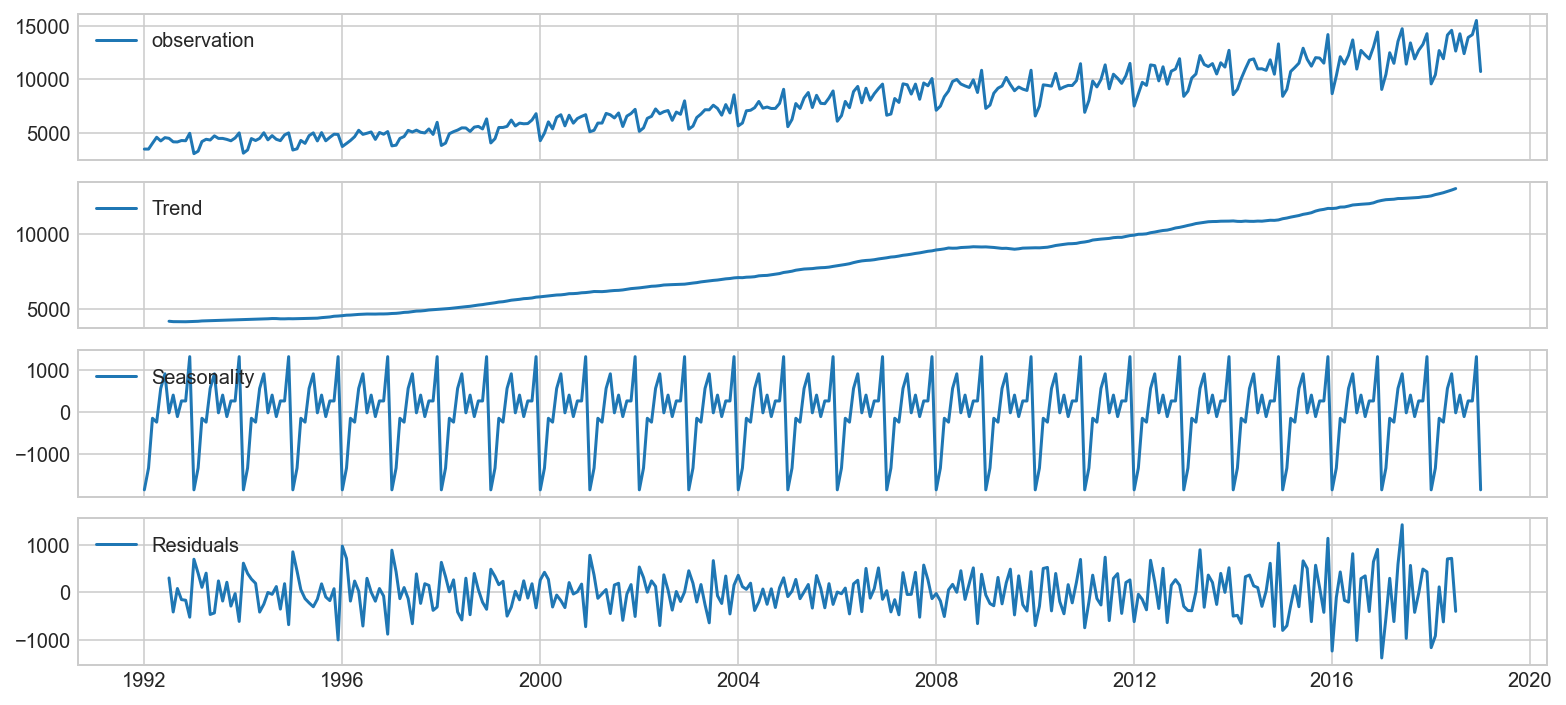

In [342]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)

axes[0].plot(estimated_obs, label='observation')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left');

In [47]:
check = normaltest(df) # nonstationary
check

NormaltestResult(statistic=masked_array(data=[34.01139982060664],
             mask=[False],
       fill_value=1e+20), pvalue=array([4.11640757e-08]))

In [48]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(df)

print("ADF: ", adf)
print("p-value:", pvalue) # nonstationary

ADF:  2.0374047259136874
p-value: 0.9987196267088919


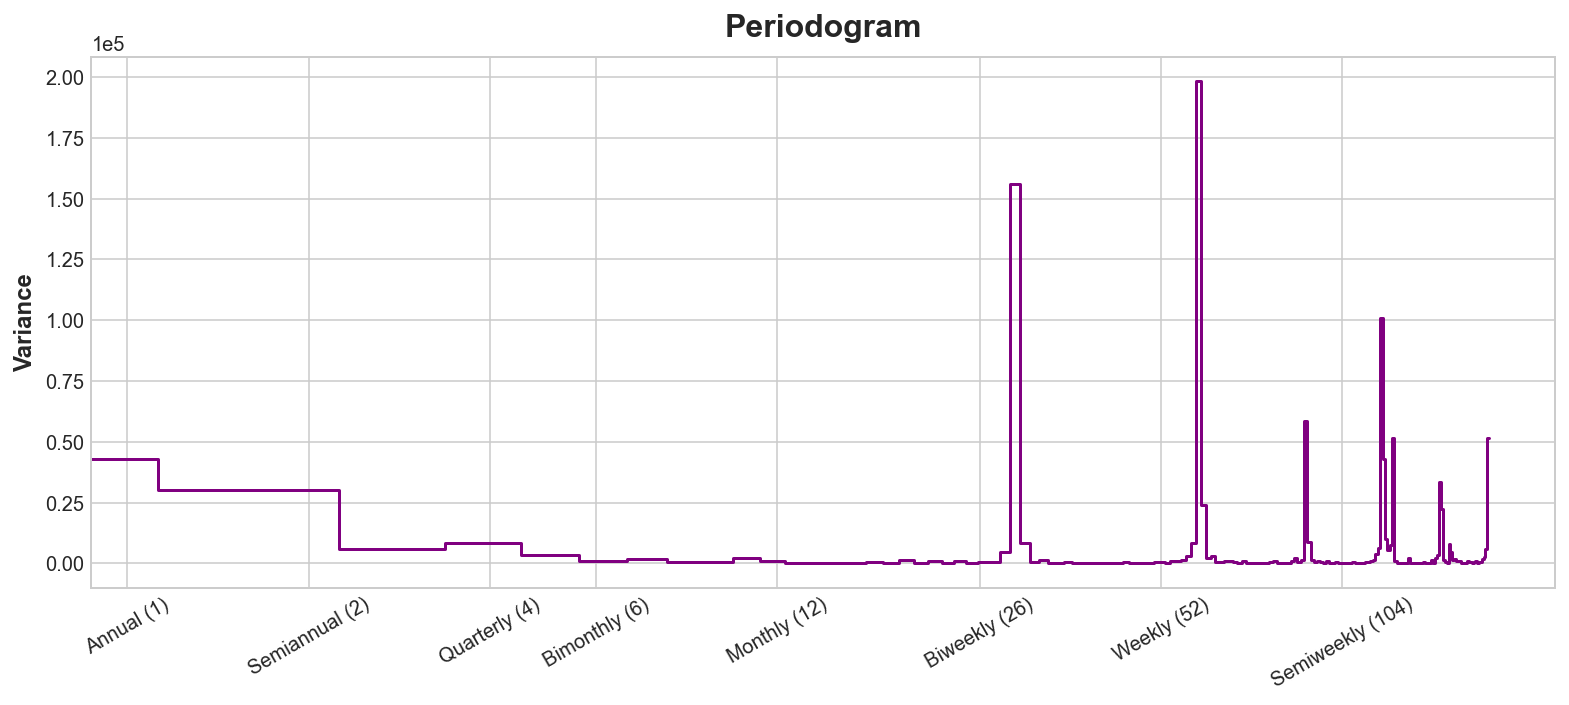

In [52]:
plot_periodogram(df['sales']); # strong annual seasonality

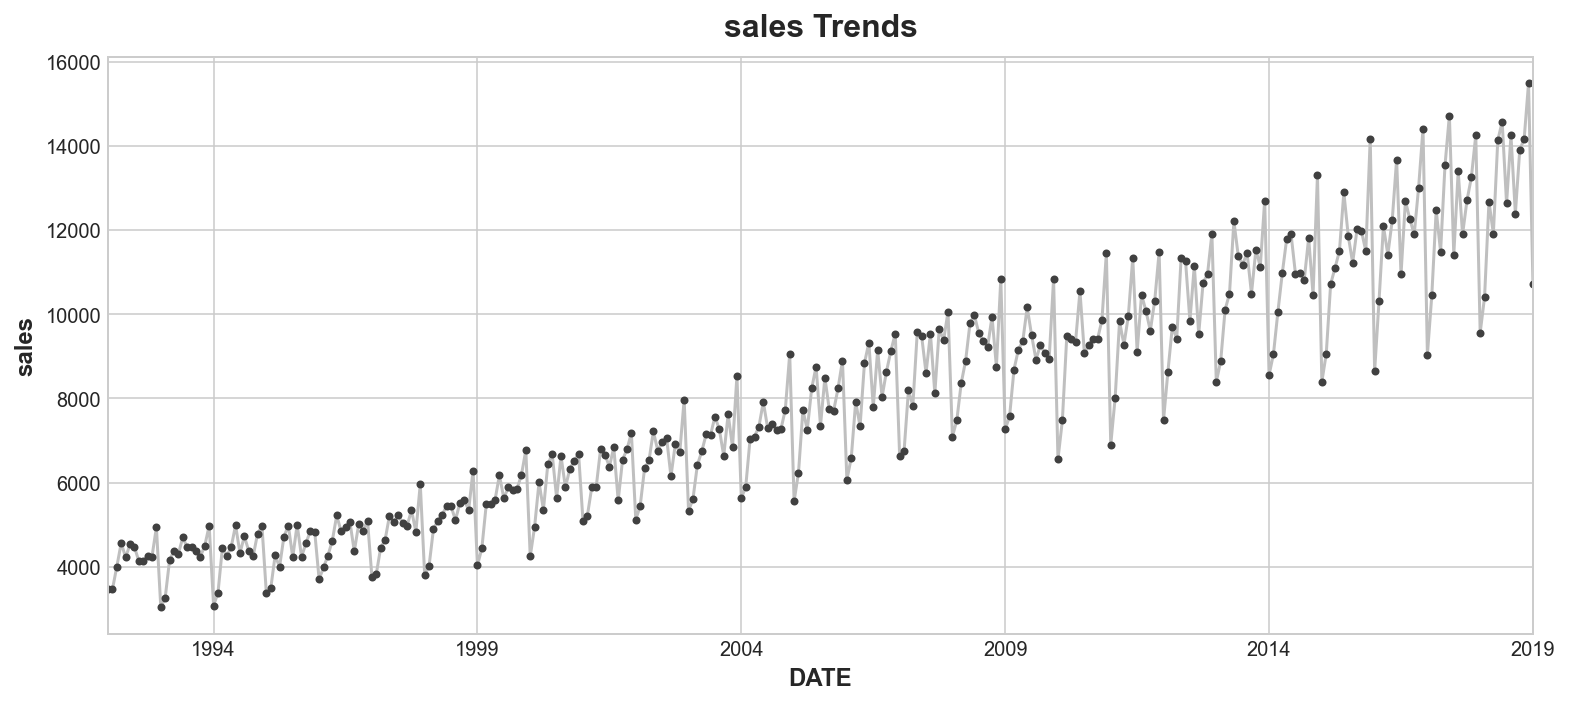

In [53]:
ax = df.sales.plot(title='sales Trends', **plot_params)
_ = ax.set(ylabel="sales")

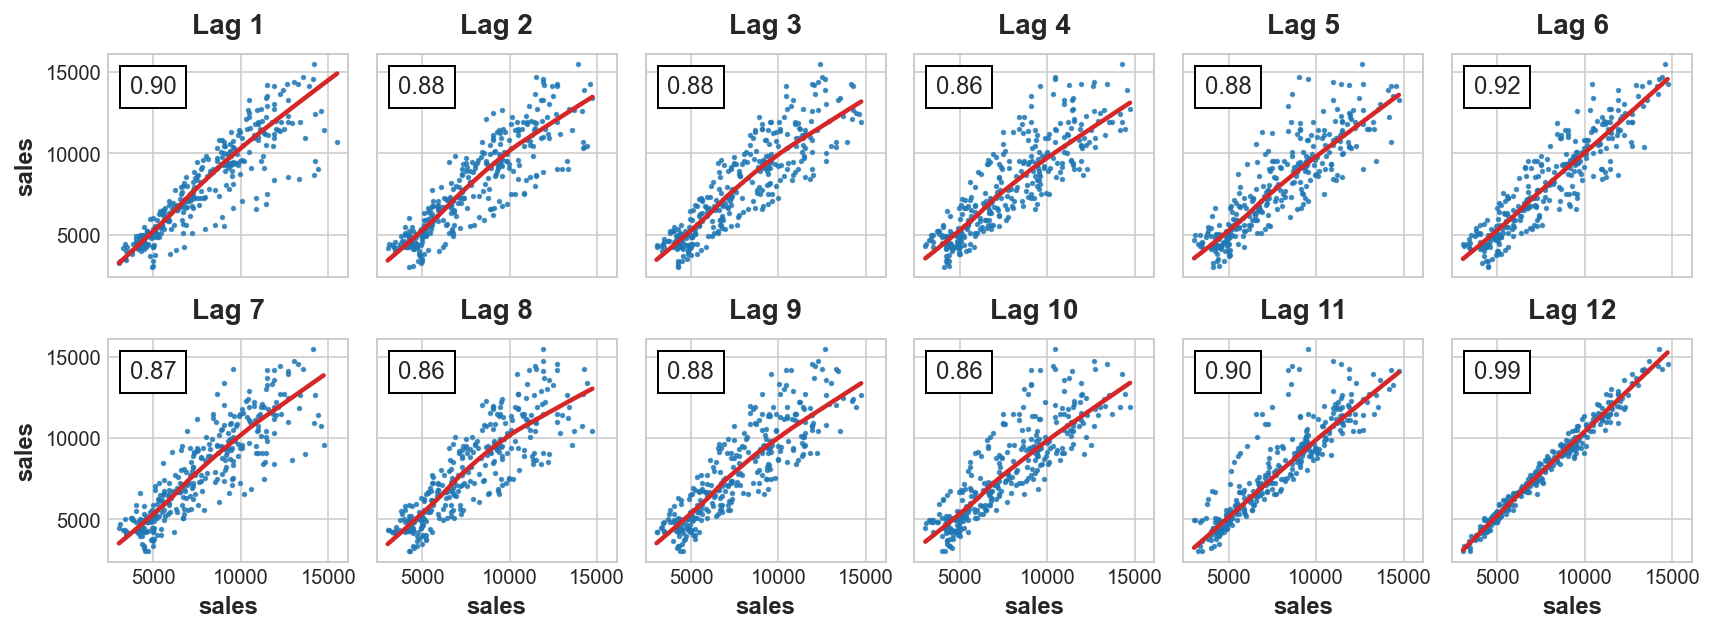

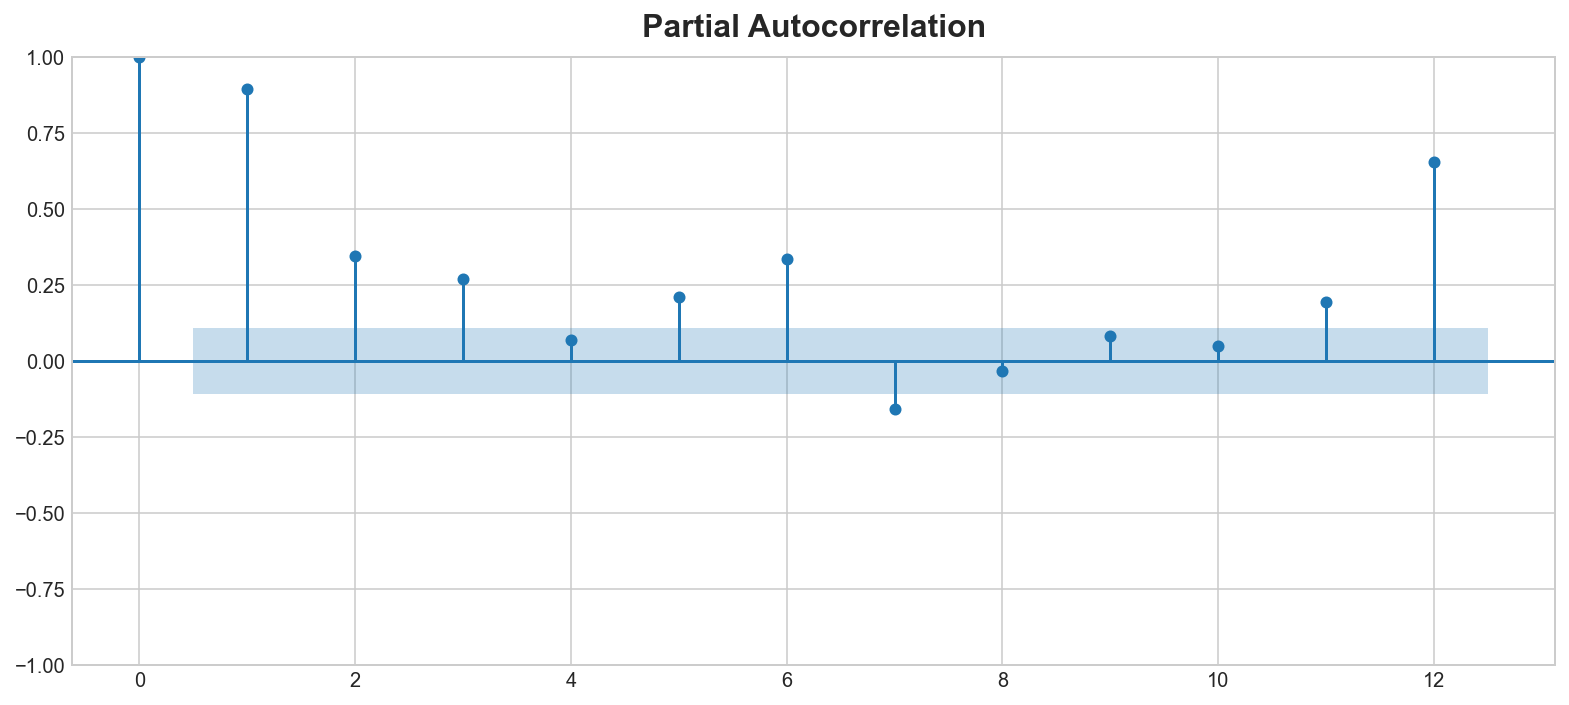

In [56]:
_ = plot_lags(df.sales, lags=12, nrows=2)
_ = plot_pacf(df.sales, lags=12) # strong lag 12

In [321]:
df = df.T # data transpose to prepare data split
df.head()

DATE,1992-01-01,1992-02-01,1992-03-01,1992-04-01,1992-05-01,1992-06-01,1992-07-01,1992-08-01,1992-09-01,1992-10-01,...,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01
sales,3459,3458,4002,4564,4221,4529,4466,4137,4126,4259,...,11919,14138,14583,12640,14257,12396,13914,14174,15504,10718


# Machine Learning

In [327]:
# Linear Regression as first model to compare

X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=12, y_len=1, test_loops=40)

reg = Pipeline([('scaler', MinMaxScaler()), ('poly', PolynomialFeatures(2)), 
                ('LinearRegression', LinearRegression())]) # Create a linear regression object

#reg = Pipeline([('scaler', MinMaxScaler()), ('LinearRegression', LinearRegression())]) # Create a linear regression object

reg.fit(X_train, y_train) # Fit it to the training data

# Create two predictions for the training and test sets
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

kpi(y_train, y_train_pred, y_test, y_test_pred, name='Regression')

               MAE    RMSE  Bias  MAE_pct  RMSE_pct  r2_score
Regression                                                   
Train       147.36  187.71 -0.00     2.00      2.54      0.99
Test        318.33  427.35  1.04     2.56      3.44      0.93


In [328]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((273, 12), (40, 12), (273,), (40,))

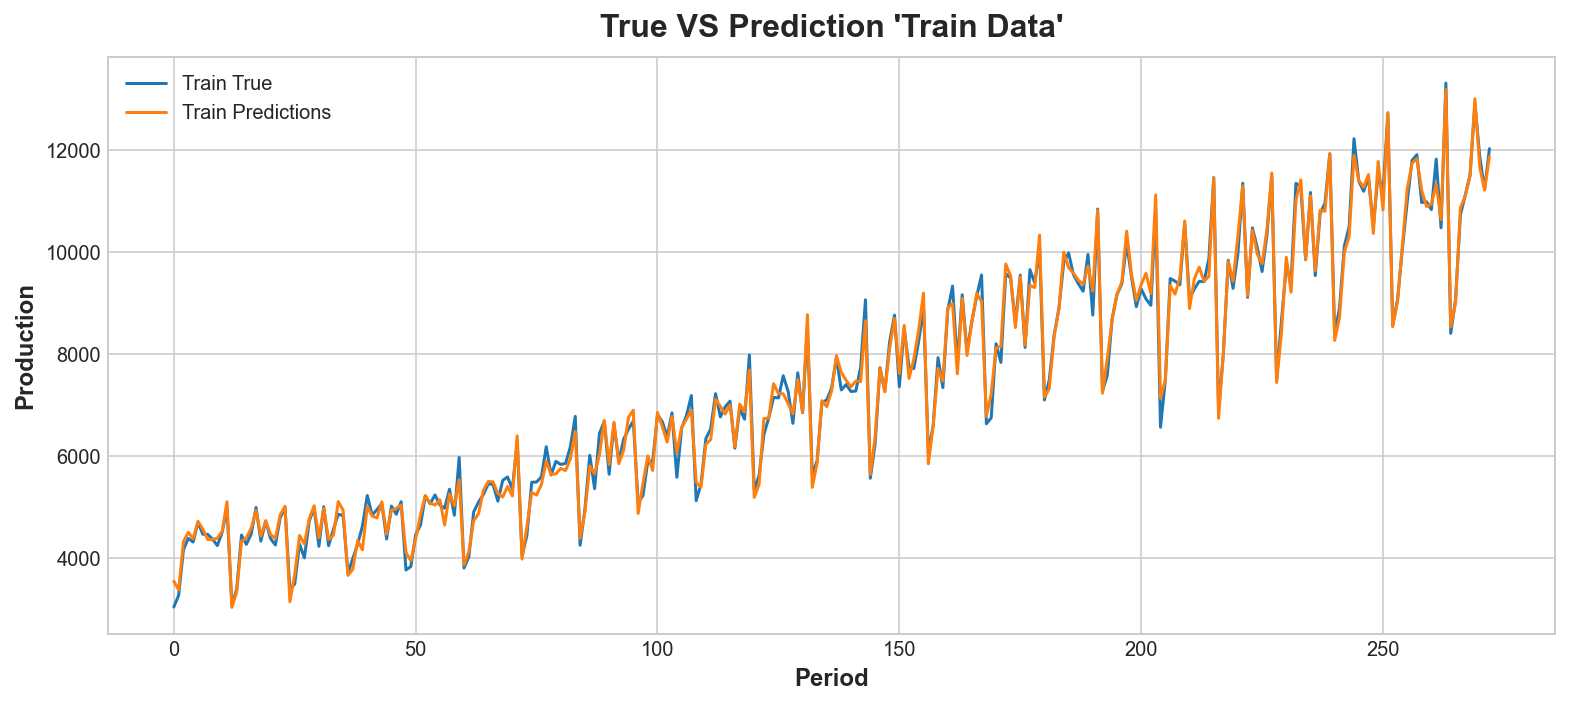

In [329]:
plt.plot(y_train, label='Train True')
plt.plot(y_train_pred, label='Train Predictions')
plt.title("True VS Prediction 'Train Data'") 
plt.xlabel("Period") 
plt.ylabel("Production")
plt.legend();

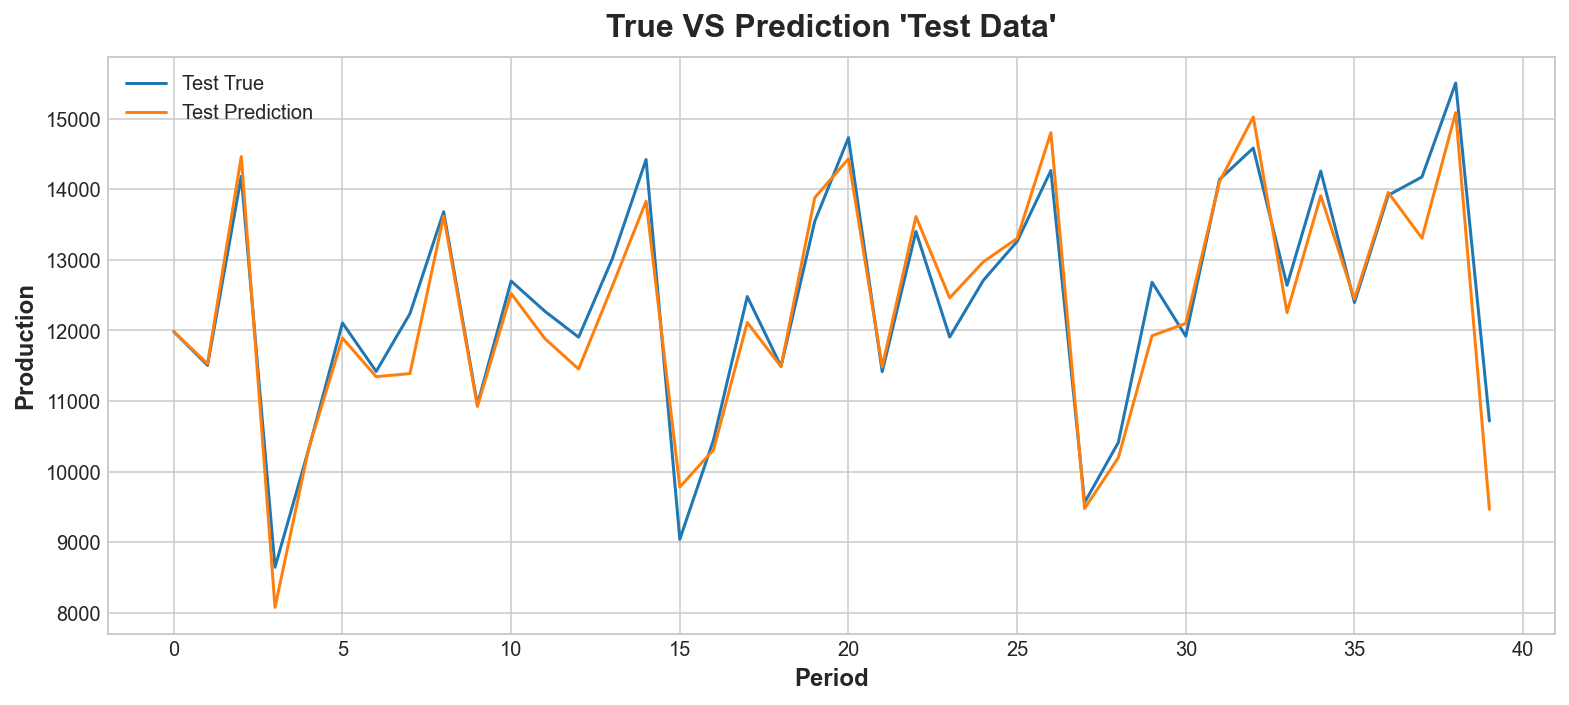

In [330]:
plt.plot(y_test, label='Test True')
plt.plot(y_test_pred, label='Test Prediction')
plt.title("True VS Prediction 'Test Data'") 
plt.xlabel("Period") 
plt.ylabel("Production")
plt.legend();

In [331]:
# prediction

X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=12, y_len=1, test_loops=0)

reg = Pipeline([('scaler', MinMaxScaler()), ('poly', PolynomialFeatures(2)), 
                ('LinearRegression', LinearRegression())]) # Create a linear regression object

reg.fit(X_train,y_train) # Fit it to the training data

reg_forecast = pd.DataFrame(data=reg.predict(X_test), index=df.index, columns=['Next_Month'])
reg_forecast

,Next_Month
sales,11332.949377


In [99]:
# use Random Forest with default parameters

X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=12, y_len=1, test_loops=25)

forest = Pipeline([('scaler', MinMaxScaler()), ('Forest', RandomForestRegressor())])

forest.fit(X_train, y_train)

y_train_pred = forest.predict(X_train) 
y_test_pred = forest.predict(X_test)

kpi(y_train, y_train_pred, y_test, y_test_pred, name='Forest')

           MAE    RMSE  Bias  MAE_pct  RMSE_pct  r2_score
Forest                                                   
Train   117.38  155.23  0.08     1.54      2.03      1.00
Test    605.49  756.21  0.54     4.80      5.99      0.79


In [100]:
X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=12, y_len=1, test_loops=25)

pipe_grid = Pipeline([('scaler', MinMaxScaler()), ('Forestb', RandomForestRegressor(n_jobs=1))])

param_dist = {'Forestb__n_estimators': list(range(100, 500, 100)),
              'Forestb__max_depth': list(range(1, 20)) + [None],
              'Forestb__min_samples_split': range(2, 20),
              'Forestb__min_samples_leaf': range(1, 20),
              'Forestb__max_features': [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1] + ['auto'],
              'Forestb__bootstrap': [True],
              'Forestb__max_samples': [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1]}

forest_cv = RandomizedSearchCV(pipe_grid, param_dist, cv=6, n_jobs=-1, verbose=1, n_iter=400)

forest_cv.fit(X_train, y_train)

print('Tuned Forest Parameters:', forest_cv.best_params_)

Fitting 6 folds for each of 400 candidates, totalling 2400 fits
Tuned Forest Parameters: {'Forestb__n_estimators': 400, 'Forestb__min_samples_split': 2, 'Forestb__min_samples_leaf': 2, 'Forestb__max_samples': 0.7, 'Forestb__max_features': 0.9, 'Forestb__max_depth': 6, 'Forestb__bootstrap': True}


In [108]:
X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=12, y_len=1, test_loops=25)

pipe_grid_f = Pipeline([('scaler', MinMaxScaler()), ('Forestf', RandomForestRegressor(n_jobs=1))])

param_dist_f = {'Forestf__n_estimators': [400],
                'Forestf__max_depth': range(5, 8),
                'Forestf__min_samples_split': range(2, 5),
                'Forestf__min_samples_leaf': range(1, 4),
                'Forestf__max_features': [.85, .9, .95],
                'Forestf__bootstrap': [True],
                'Forestf__max_samples': [.65, .7, .75]}

forest_cv_f = GridSearchCV(pipe_grid_f, param_dist_f, n_jobs=-1, verbose=1)

forest_cv_f.fit(X_train, y_train)

print('Tuned Forest Parameters:', forest_cv_f.best_params_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Tuned Forest Parameters: {'Forestf__bootstrap': True, 'Forestf__max_depth': 7, 'Forestf__max_features': 0.95, 'Forestf__max_samples': 0.75, 'Forestf__min_samples_leaf': 1, 'Forestf__min_samples_split': 2, 'Forestf__n_estimators': 400}


In [110]:
X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=12, y_len=1, test_loops=25)

forest_final = Pipeline([('scaler', MinMaxScaler()), ('ForestFinal', RandomForestRegressor(n_estimators=400, 
                                                                                           min_samples_split=2, 
                                                                                           min_samples_leaf=1, 
                                                                                           max_samples=0.75, 
                                                                                           max_features=0.95, 
                                                                                           max_depth=7, 
                                                                                           bootstrap=True))])

forest_final.fit(X_train, y_train)  
 
y_train_pred = forest_final.predict(X_train)
y_test_pred = forest_final.predict(X_test)

kpi(y_train, y_train_pred, y_test, y_test_pred, name='forest_final')

                 MAE    RMSE  Bias  MAE_pct  RMSE_pct  r2_score
forest_final                                                   
Train         160.06  211.38  0.09     2.10      2.77      0.99
Test          689.79  849.65  1.38     5.46      6.73      0.74


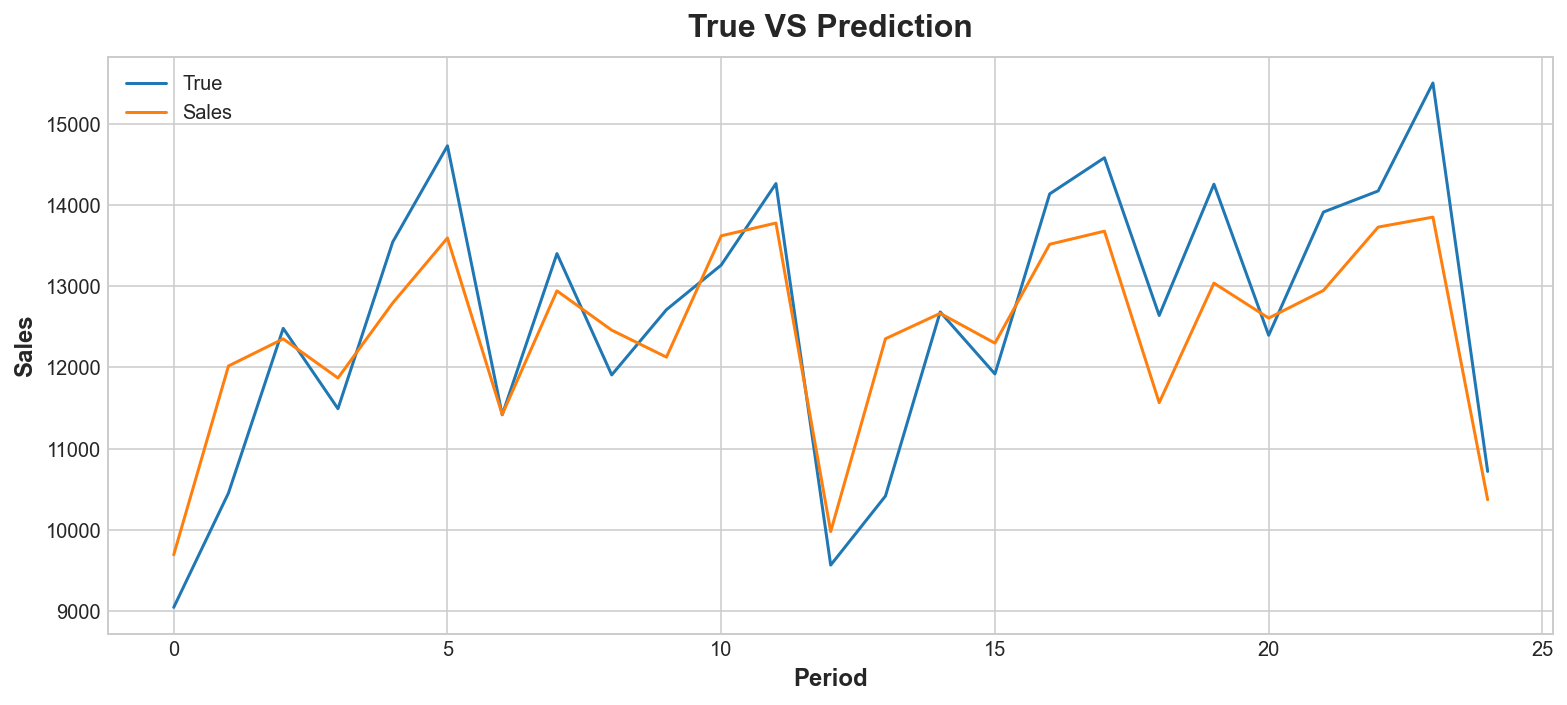

In [111]:
plt.plot(y_test, label='True')
plt.plot(y_test_pred, label='Sales')
plt.title("True VS Prediction") 
plt.xlabel("Period") 
plt.ylabel("Sales")
plt.legend();

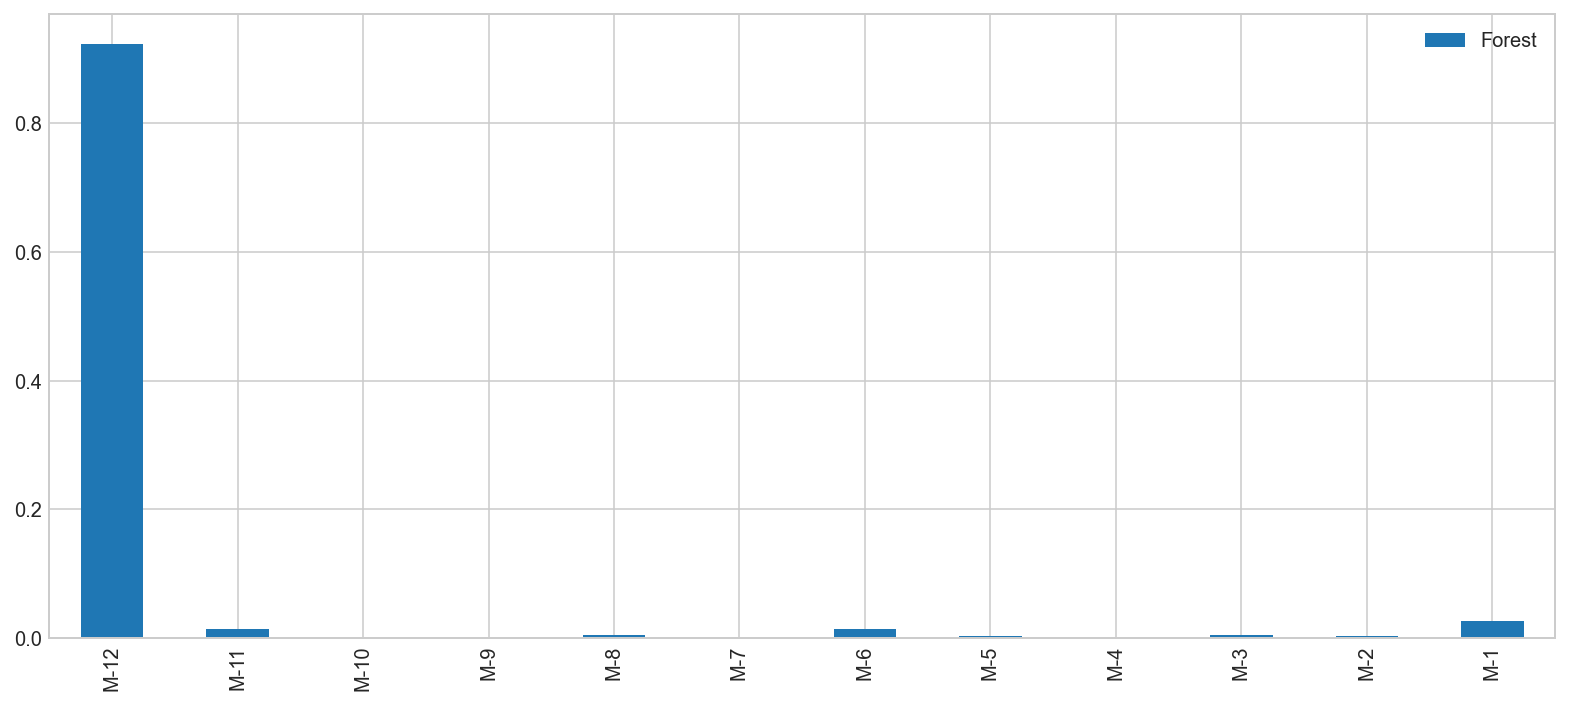

In [112]:
cols = X_train.shape[1]
features = [f'M-{cols-col}' for col in range(cols)]  
data = forest_final.steps[1][1].feature_importances_.reshape(-1,1)
imp = pd.DataFrame(data=data, index=features, columns=['Forest'])
imp.plot(kind='bar'); # the most important month is the same month but in the previous year

In [114]:
# prediction

X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=12, y_len=1, test_loops=0)

forest_final = Pipeline([('scaler', MinMaxScaler()), ('ForestFinal', RandomForestRegressor())]) #n_estimators=100, 
                                                                                           #min_samples_split=3, 
                                                                                           #min_samples_leaf=1, 
                                                                                           #max_samples=0.8, 
                                                                                           #max_features=0.9, 
                                                                                           #max_depth=12, 
                                                                                           #bootstrap=True))])

forest_final.fit(X_train, y_train) # Fit it to the training data

forecast = pd.DataFrame(data=forest_final.predict(X_test), index=df.index)
forecast

,0
sales,11290.6


In [115]:
# XGB model to predict one period

X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=12, y_len=1, test_loops=25)

xgb_pipe = Pipeline([('scaler', MinMaxScaler()), ('xgb', XGBRegressor())]) # predict 1 period

xgb_pipe.fit(X_train, y_train)  
 
y_train_pred = xgb_pipe.predict(X_train)
y_test_pred = xgb_pipe.predict(X_test)

kpi(y_train, y_train_pred, y_test, y_test_pred, name='xgb')

          MAE    RMSE  Bias  MAE_pct  RMSE_pct  r2_score
xgb                                                     
Train    0.65    0.90 -0.00     0.01      0.01      1.00
Test   632.18  782.21  1.54     5.01      6.20      0.78


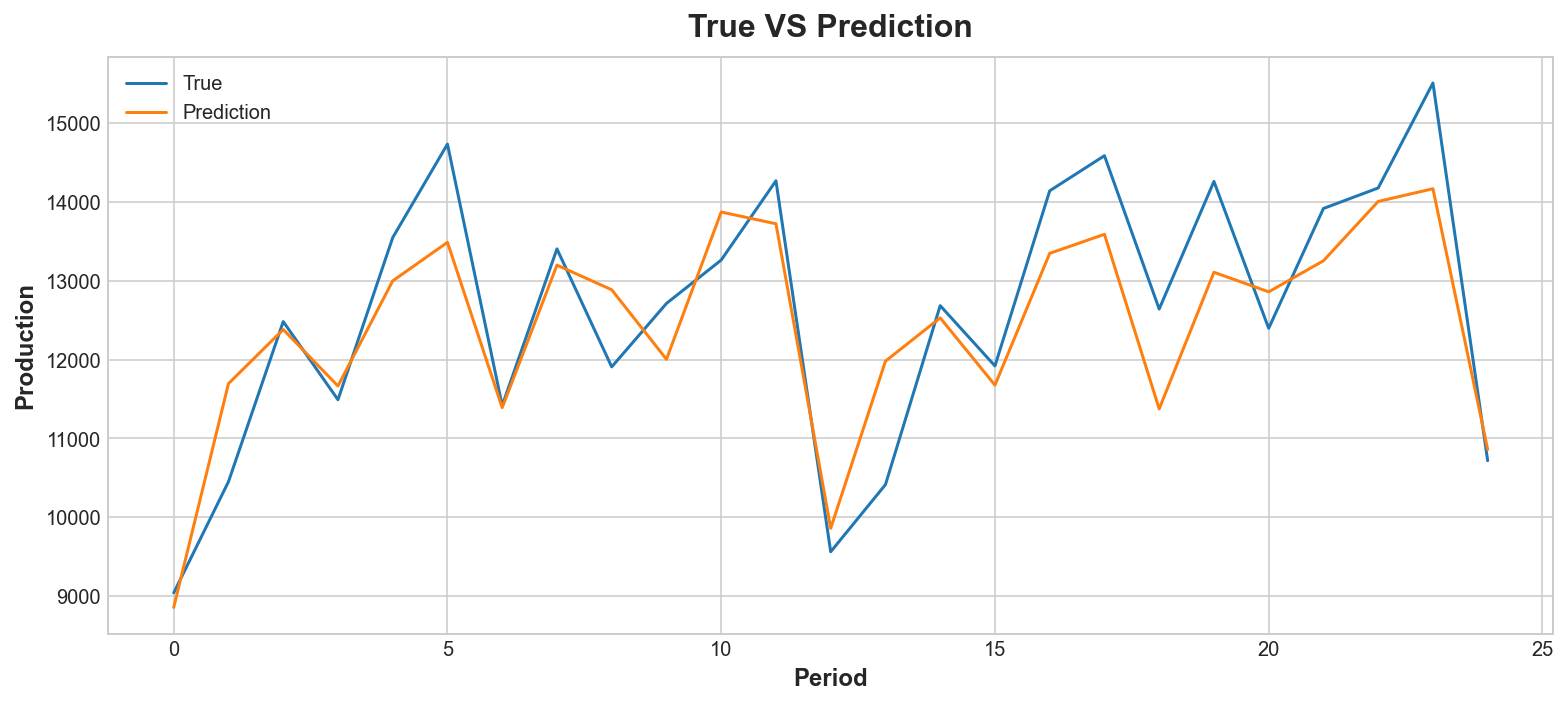

In [116]:
plt.plot(y_test, label='True')
plt.plot(y_test_pred, label='Prediction')
plt.title("True VS Prediction") 
plt.xlabel("Period") 
plt.ylabel("Production")
plt.legend();

In [117]:
# MultiRegressor using XGB model to predict more than one period

X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=12, y_len=2, test_loops=25)

mul_pipe = Pipeline([('scaler', MinMaxScaler()), ('mul', MultiOutputRegressor(XGBRegressor(), n_jobs=-1))])

mul_pipe.fit(X_train, y_train)  
 
y_train_pred = mul_pipe.predict(X_train) 
y_test_pred = mul_pipe.predict(X_test)

kpi(y_train, y_train_pred, y_test, y_test_pred, name='Multi')

          MAE    RMSE  Bias  MAE_pct  RMSE_pct  r2_score
Multi                                                   
Train    0.73    0.99  0.00     0.01      0.01      1.00
Test   761.03  928.57  3.45     5.99      7.32      0.69


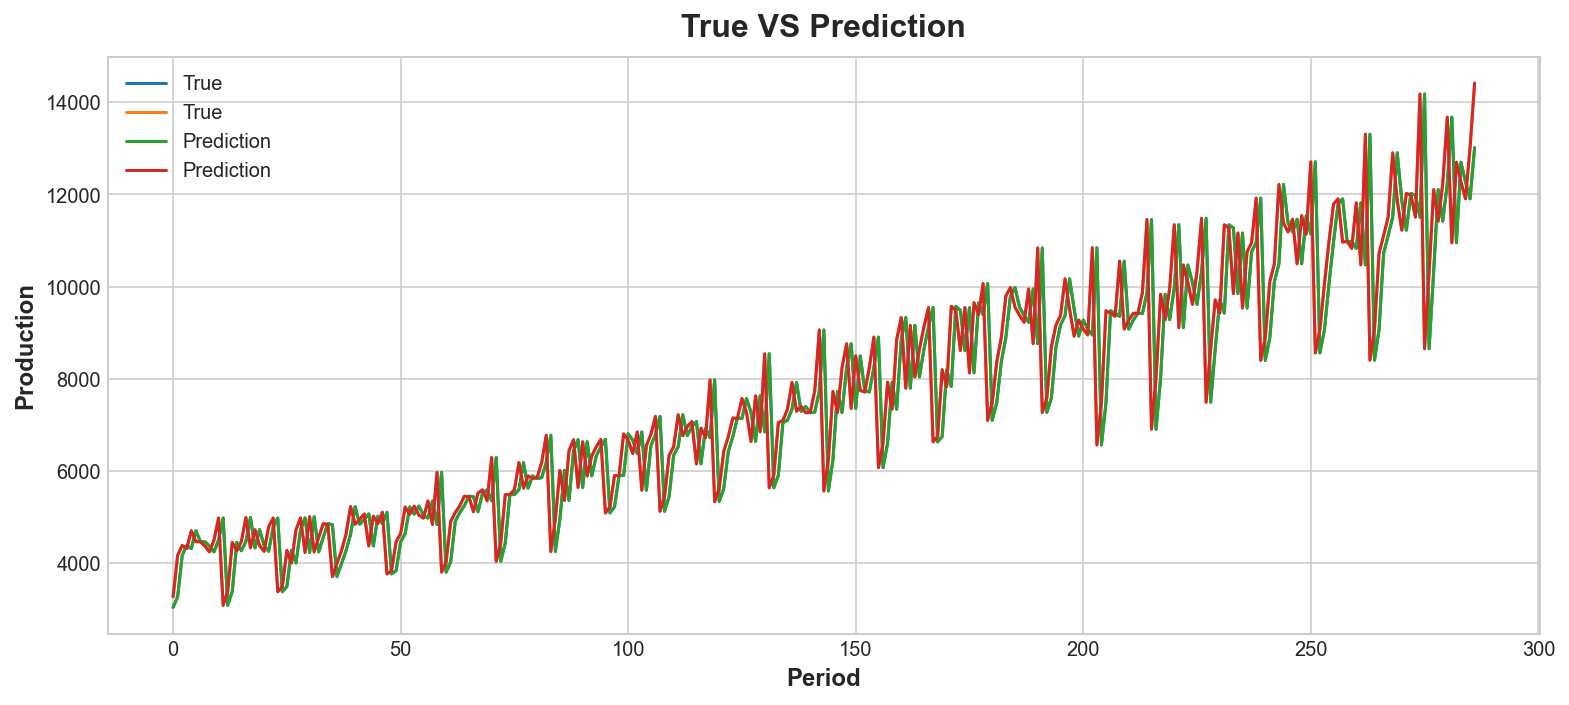

In [118]:
plt.plot(y_train, label='True')
plt.plot(y_train_pred, label='Prediction')
plt.title("True VS Prediction") 
plt.xlabel("Period") 
plt.ylabel("Production")
plt.legend();

In [119]:
# prediction

X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=12, y_len=2, test_loops=0)

mul_pipe = Pipeline([('scaler', MinMaxScaler()), ('mul', MultiOutputRegressor(XGBRegressor(), n_jobs=-1))])

mul_pipe.fit(X_train, y_train) # Fit it to the training data

forecast = pd.DataFrame(data=mul_pipe.predict(X_test), index=df.index)
forecast

,0,1
sales,10679.700195,12759.816406


# LSTM Deep Learning

In [305]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [306]:
df = pd.read_csv('Alcohol_Sales.csv', index_col='DATE', parse_dates=True)
df.index.freq = 'MS'
df.columns = ['sales']
df.head()

,sales
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [307]:
scaler = MinMaxScaler()
data = scaler.fit_transform(df)

# Split
cut = int(len(data) *0.9)

train, test = data[:cut,:], data[cut:,:]

In [308]:
n_steps = 12
n_features = 1

X_train, y_train = split_sequence(train, n_steps)
X_test, y_test = split_sequence(test, n_steps)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((280, 12, 1), (21, 12, 1), (280, 1), (21, 1))

In [309]:
# reshape from [samples, timesteps] into [samples, timesteps, features]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((280, 12, 1), (21, 12, 1), (280, 1), (21, 1))

In [310]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


model = tf.keras.models.Sequential([tf.keras.layers.Conv1D(filters=60, 
                                                           kernel_size=5, 
                                                           strides=1, 
                                                           padding="causal", 
                                                           activation="relu", 
                                                           input_shape=(n_steps, n_features)), 
                                    tf.keras.layers.LSTM(60, return_sequences=True), 
                                    tf.keras.layers.LSTM(60), tf.keras.layers.Dense(1), 
                                    tf.keras.layers.Lambda(lambda x: x * 400)])


model.compile(loss='mean_squared_error',optimizer='adam')

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100 ,batch_size=8, verbose=0)

In [311]:
y_train = scaler.inverse_transform(y_train)
y_train_pred = scaler.inverse_transform(model.predict(X_train))

y_test = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(model.predict(X_test))

kpi(y_train, y_train_pred, y_test, y_test_pred, name='LSTM')

          MAE    RMSE  Bias  MAE_pct  RMSE_pct  r2_score
LSTM                                                    
Train  449.17  512.13  4.99     6.00      6.84      0.96
Test   469.31  591.55  0.13     3.62      4.56      0.85


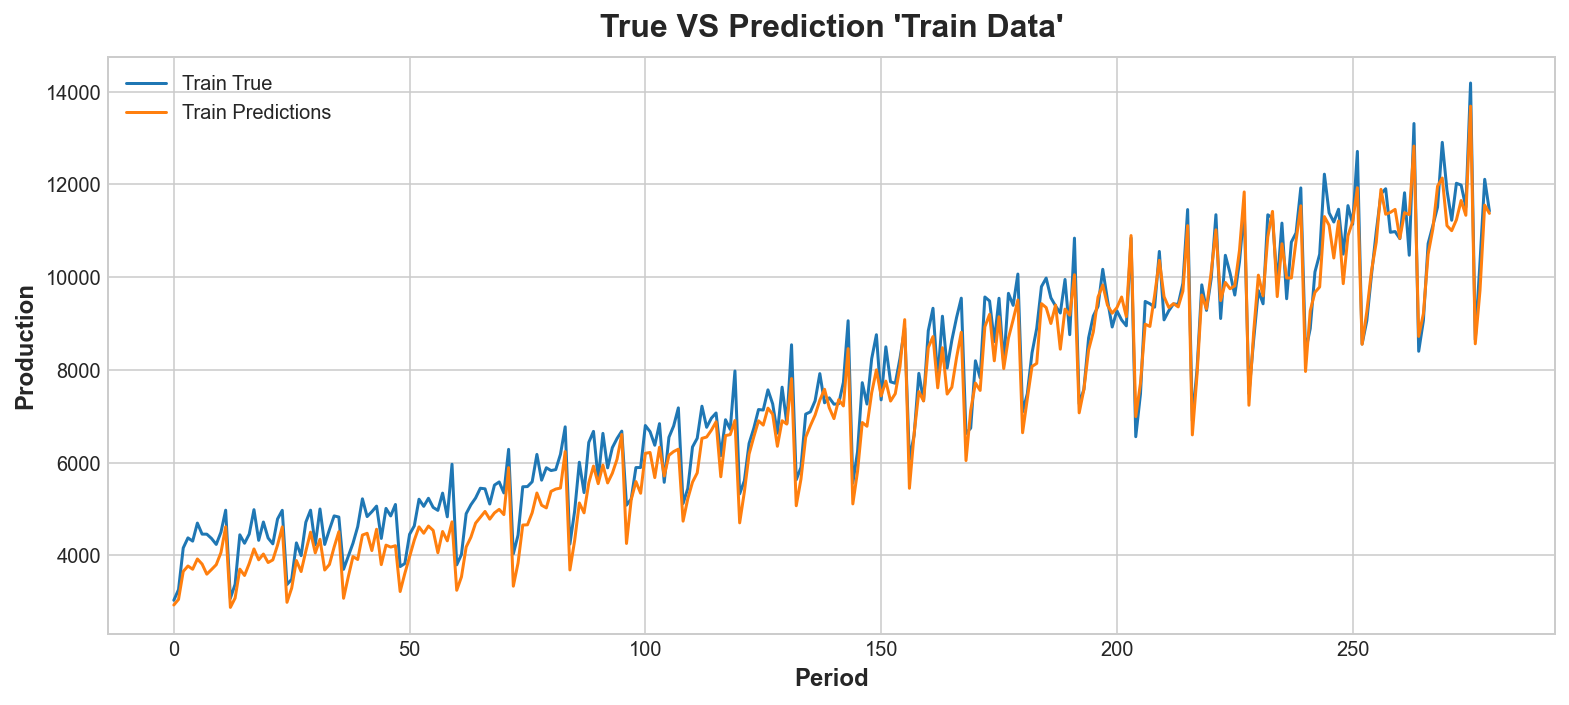

In [313]:
plt.plot(y_train, label='Train True')
plt.plot(y_train_pred, label='Train Predictions')
plt.title("True VS Prediction 'Train Data'") 
plt.xlabel("Period") 
plt.ylabel("Production")
plt.legend();

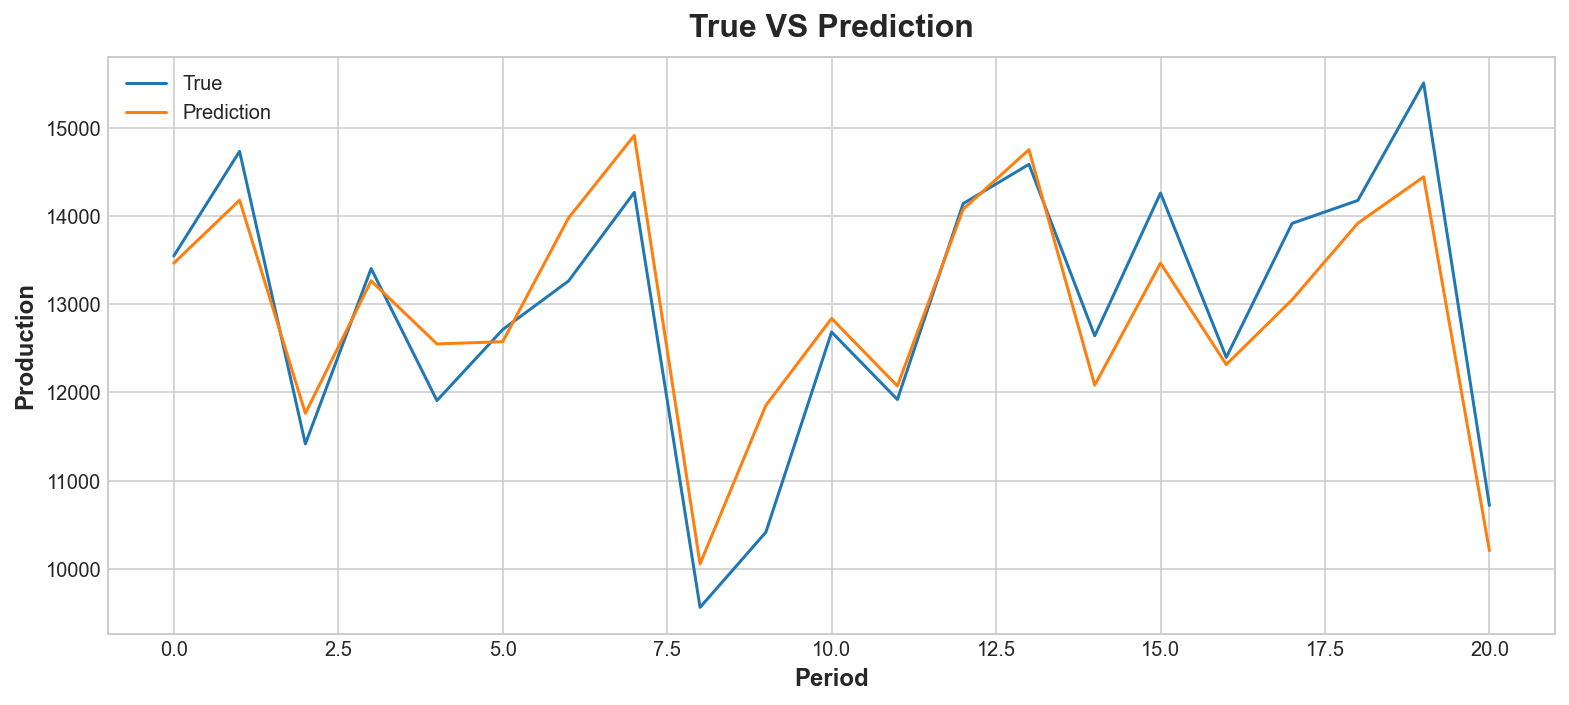

In [314]:
plt.plot(y_test, label='True')
plt.plot(y_test_pred, label='Prediction')
plt.title("True VS Prediction") 
plt.xlabel("Period") 
plt.ylabel("Production")
plt.legend();

In [312]:
# demonstrate prediction
future_pred = data[-n_steps:]
x_input = future_pred
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
yhat = scaler.inverse_transform(yhat)
print('Prediction of Next Month Production is: ', round(float(yhat), 2))

Prediction of Next Month Production is:  11694.44


# Concolusion
- Sales has upword Trend.
- sales has annual seasonality.
- Linear Regression is the best model to predict next month sales.